In [1]:
pip install langchain-google-genai

Note: you may need to restart the kernel to use updated packages.


In [26]:
"""
HR Supervisor Multi-Agent System using LangGraph
Supervisor agent intelligently routes to compensation and leave management specialists
"""

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool, InjectedToolCallId
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent, InjectedState
from typing import Annotated
import os

# Setup
google_api_key = os.environ["GOOGLE_API_KEY"]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

# Compensation Tools
@tool
def get_salary(position: str) -> str:
    """Get salary range for a position"""
    salaries = {
        "engineer": "$80k-120k", 
        "manager": "$100k-140k",
        "director": "$150k-200k"
    }
    return salaries.get(position.lower(), "$50k-200k range")

@tool
def calculate_bonus(salary: str, rating: str) -> str:
    """Calculate bonus based on salary and performance rating"""
    try:
        sal = int(salary.replace('k', '000').replace('$', '').replace(',', ''))
        multiplier = {"excellent": 0.15, "good": 0.10, "average": 0.05}.get(rating.lower(), 0.05)
        return f"Bonus: ${sal * multiplier:,.0f}"
    except:
        return "Bonus: 5-15% of salary based on performance"

# Leave Tools  
@tool
def check_leave_balance(employee_id: str) -> str:
    """Check employee leave balance"""
    balances = {
        "emp001": "Vacation: 15 days, Sick: 8 days",
        "emp002": "Vacation: 22 days, Sick: 12 days"
    }
    return balances.get(employee_id, "Standard: Vacation: 20 days, Sick: 10 days")

@tool
def submit_leave(employee_id: str, days: str, leave_type: str) -> str:
    """Submit leave request"""
    return f"Leave request submitted for {employee_id}: {days} days of {leave_type}. Request ID: LR{hash(employee_id)%1000:03d}"

# Create Handoff Tools for Supervisor
def create_handoff_tool(*, agent_name: str, description: str):
    name = f"transfer_to_{agent_name}"
    
    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto=agent_name,
            update={**state, "messages": state["messages"] + [tool_message]},
            graph=Command.PARENT,
        )
    
    return handoff_tool

# Handoff tools
transfer_to_compensation = create_handoff_tool(
    agent_name="compensation_agent",
    description="Transfer to compensation specialist for salary, bonus, and benefits questions"
)

transfer_to_leave = create_handoff_tool(
    agent_name="leave_agent", 
    description="Transfer to leave management specialist for vacation, sick leave, and time-off questions"
)

# Create Worker Agents
compensation_agent = create_react_agent(
    llm,
    [get_salary, calculate_bonus],
    prompt=(
        "You are a compensation specialist.\n\n"
        "INSTRUCTIONS:\n"
        "- Help ONLY with salary, bonus, and benefits questions\n"
        "- Use your tools to provide accurate information\n"
        "- After completing your task, respond directly with the results\n"
        "- Keep responses concise and helpful"
    ),
    name="compensation_agent",
)

leave_agent = create_react_agent(
    llm,
    [check_leave_balance, submit_leave],
    prompt=(
        "You are a leave management specialist.\n\n"
        "INSTRUCTIONS:\n"
        "- Help ONLY with vacation, sick leave, and time-off questions\n"
        "- Use your tools to check balances and submit requests\n"
        "- After completing your task, respond directly with the results\n"
        "- Keep responses concise and helpful"
    ),
    name="leave_agent",
)

# Create Supervisor Agent
supervisor_agent = create_react_agent(
    llm,
    [transfer_to_compensation, transfer_to_leave],
    prompt=(
        "You are an HR supervisor managing two specialist agents:\n"
        "- compensation_agent: handles salary, bonus, and benefits questions\n"
        "- leave_agent: handles vacation, sick leave, and time-off questions\n\n"
        "INSTRUCTIONS:\n"
        "- Analyze each request and transfer to the appropriate specialist\n"
        "- Transfer to ONE agent at a time, do not call agents in parallel\n"
        "- Do not do any work yourself, always delegate to specialists\n"
        "- Use the transfer tools to route requests properly"
    ),
    name="supervisor",
)

# Build Multi-Agent Graph
supervisor_graph = (
    StateGraph(MessagesState)
    .add_node("supervisor", supervisor_agent, destinations=["compensation_agent", "leave_agent", END])
    .add_node("compensation_agent", compensation_agent)
    .add_node("leave_agent", leave_agent)
    .add_edge(START, "supervisor")
    .add_edge("compensation_agent", "supervisor")
    .add_edge("leave_agent", "supervisor")
    .compile()
)

# Helper function for pretty printing
def pretty_print_message(message, indent=False):
    if hasattr(message, 'content'):
        content = message.content
        if hasattr(message, 'name') and message.name:
            content = f"[{message.name}]: {content}"
        
        if indent:
            content = "\t" + content
        print(content)

def pretty_print_messages(update, last_message=False):
    for node_name, node_update in update.items():
        print(f"Update from {node_name}:")
        
        if "messages" in node_update:
            messages = node_update["messages"]
            if last_message and messages:
                messages = messages[-1:]
            
            for msg in messages:
                pretty_print_message(msg, indent=True)
        print()

# Usage
if __name__ == "__main__":
    print("=== HR Supervisor Multi-Agent System ===\n")
    # Test cases
    queries = [
        "What's the salary range for an engineer and check leave balance for emp001?",
        # "Check leave balance for emp001", 
        # "Calculate bonus for $100k salary with excellent performance",
        # "Submit 5 days vacation request for emp002"
    ]
    
    for i, query in enumerate(queries, 1):
        print(f"{i}. Query: {query}")
        print("-" * 50)
        
        # Stream the response to see the routing in action
        for chunk in supervisor_graph.stream({
            "messages": [HumanMessage(content=query)]
        }):
            pretty_print_messages(chunk, last_message=True)
        
        print("=" * 60)
        print()


=== HR Supervisor Multi-Agent System ===

1. Query: What's the salary range for an engineer and check leave balance for emp001?
--------------------------------------------------
Update from supervisor:

Update from compensation_agent:
	[compensation_agent]: The salary range for an engineer is $80k-120k. I am unable to check the leave balance.

Update from supervisor:

Update from leave_agent:
	[leave_agent]: Vacation: 15 days, Sick: 8 days

Update from supervisor:
	[supervisor]: 




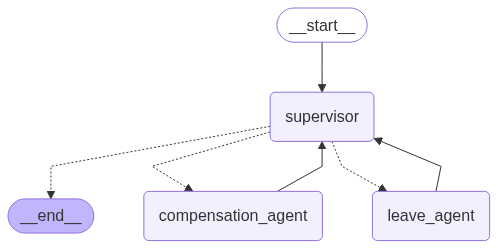

In [16]:
from IPython.display import display, Image

display(Image(supervisor_graph.get_graph().draw_mermaid_png()))